# Week 12: An Improvement on Boundary Corner
Improving the algorithm implemented last week[[1]](#ref-1)

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [1]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

C:\Tool\Env\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<a name='1'></a>
## 1 - Test Example

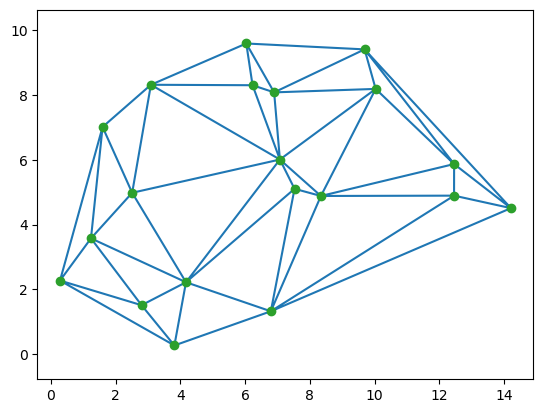

In [36]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=15
points[:, 1]*=10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

In [5]:
monitor_id=1

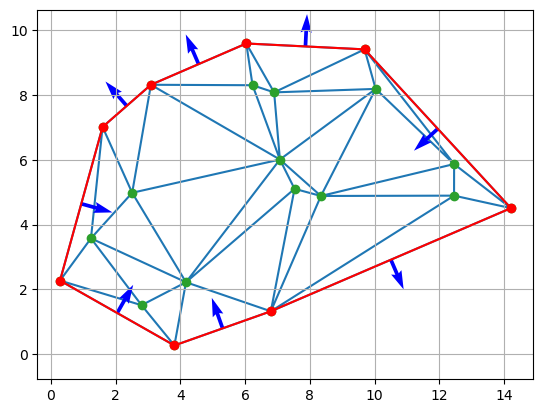

In [37]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


In [38]:
faces=tri.simplices.copy()
vertices=points.copy()
boundary_edges = retrieve_boundary_edges(tri.simplices)

In [39]:
lambda1=1
lambda2=1
num_iter = 30

<a name='2'></a>
## 2 - The Loss Function

$$Loss = E^A + E^B$$

$E^A$ is the angle term.

$$E^A = \sum_{\theta \in b} activation(\theta)$$

$$
activation(\theta) = 
\begin{cases} 
\frac{\cos^2(\theta)}{\theta} & 0 < \theta < \frac{\pi}{2} \\
\cos^2(\theta) & \frac{\pi}{2} < \theta < \pi
\end{cases}
$$



$E^B$ is the alignment term. The algorithm only measure the alignment of boundary edges.

$$E^B = \sum_{i \in b} L_i(||n_i||-1)$$

$\lambda$ is the hyper-parameter to balance the two terms.

In [40]:
def activation(angle):
#     return np.cos(angle) * np.sin(2*angle) / angle
    if angle < (np.pi/2):
        return np.power(np.cos(angle), 2) / angle
    else:
        return np.power(np.cos(angle), 2)
        

In [41]:
def energy_designed(x):
    X = x.reshape((v_num, 2))
    
    EB = 0
    for edge in boundary_edges:
        A, B = X[edge[0]], X[edge[1]]
        EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
        
    
    EA = 0
    boundary_angles = retrieve_boundary_angles_2D(boundary_edges, X)
    for angle_value in boundary_angles.values():
#         EA += np.power(np.cos(angle_value), 2)
        EA += activation(angle_value)
        
    return lambda1*EB + lambda2*EA

In [42]:
x0 = np.ravel(vertices)
res_designed = minimize(energy_designed, x0, options = {'maxiter': 100}
#                , method='BFGS'
              )
vertices_designed = res_designed.x.reshape((v_num,2))

<a name='3'></a>
## 3 - Result

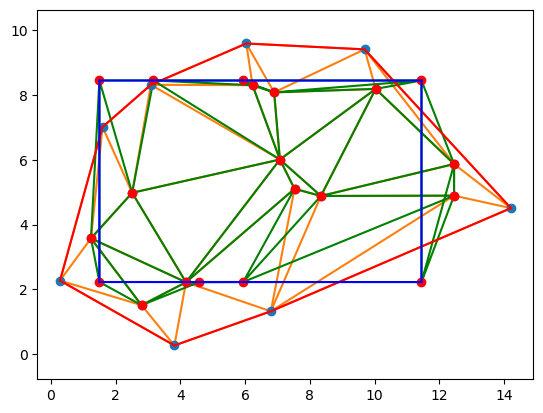

In [43]:
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(vertices_designed[:,0], vertices_designed[:,1], 'o', color='red')
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.triplot(vertices_designed[:,0], vertices_designed[:,1], tri.simplices, color='green')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
    plt.plot(vertices_designed[np.array(edge), 0], vertices_designed[np.array(edge), 1], 'b-')
plt.axis('equal')
# plt.legend()
plt.show()

<a name='4'></a>
## 4 - Intuition of Activation of Angle

I introduce the angle constrain $E^A$ to prevent boundary edges collapse. If the boundary purely bounded by the aglinment of boundary egdes collapse to a same direction, for example +X. So I add one term to measure the angles of boundary vertices. There is four situations:

+ When $\theta \to 0$, I greatly penalize it to avoid collapse of two boundary edges
+ When $\theta \to \frac{\pi}{2}$, $E^A \to 0$
+ When $\theta \to \pi$, $E^A \to 0$
+ When $\theta \in [\frac{\pi}{2}, \pi]$, use quadratic terms to penalize it

The objective function is like:

![The activation function](plot/Activation.png)

## 5 - Problems

<a name='6'></a>
## 6 - Reference

<!-- <a name='ref-1'></a>
1. [Liu C, Yu W, Chen Z, et al. Distributed poly-square mapping for large-scale semi-structured quad mesh generation[J]. Computer-Aided Design, 2017, 90: 5-17.](https://www.sciencedirect.com/science/article/pii/S0010448517300714?casa_token=JiylsQjWSkQAAAAA:RnbFGyT8qf-EsojvYlxX-if7lhZx1TwO8i0XjTwlYa-y1AqIkVAOJHRwOm5VrxhaAUkET4LSkRc)
<a name='ref-2'></a>
1. [Hormann K, Greiner G. MIPS: An efficient global parametrization method[J]. Curve and Surface Design: Saint-Malo 1999, 2000: 153-162.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=02e4f09c9a6d0d770d31c9289d30b7b4e9b5d974) -->